In [1]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import os

from itertools import cycle

import tensorflow as tf

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model

from tensorflow.keras.layers import Dropout, Dense, AveragePooling2D, Flatten ,Dense, Input

from sklearn.metrics import classification_report, confusion_matrix

import cv2

from sklearn.metrics import roc_curve, auc

from sklearn.preprocessing import label_binarize

from scipy import interp

from sklearn.ensemble import RandomForestClassifier

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import MobileNetV2

from tensorflow.keras.optimizers import Adam

/home/rupamay/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
! git clone https://github.com/prajnasb/observations.git

fatal: destination path 'observations' already exists and is not an empty directory.


In [3]:
filenames = os.listdir("/home/rupamay/Downloads/observations/experiments/data/with_mask")

In [4]:
np.random.shuffle(filenames)

In [5]:
with_mask_data = [cv2.resize(cv2.imread("observations/experiments/data/with_mask/"+img), (224,224)) for img in filenames]

In [6]:
print(len(with_mask_data))

690


In [7]:
filenames = os.listdir("/home/rupamay/Downloads/observations/experiments/data/without_mask")

In [8]:
np.random.shuffle(filenames)

In [9]:
without_mask_data = [cv2.resize(cv2.imread("observations/experiments/data/without_mask/"+img), (224,224)) for img in filenames]

In [10]:
print(len(without_mask_data))

686


In [11]:
data = np.array(with_mask_data + without_mask_data).astype('float32')/255

In [12]:
labels = np.array([0]*len(with_mask_data) + [1]*len(without_mask_data))

In [13]:
print(data.shape)

(1376, 224, 224, 3)


In [14]:
(training_data, testing_data, training_label, testing_label) = train_test_split(data, labels, test_size=0.50, stratify=labels, random_state=42)

In [15]:
print(training_data.shape)

(688, 224, 224, 3)


In [16]:
def plot_acc_loss(result, epochs):

    acc = result.history['accuracy']

    loss = result.history['loss']

    val_acc = result.history['val_accuracy']

    val_loss = result.history['val_loss']

    plt.figure(figsize=(15, 5))

    plt.subplot(121)

    plt.plot(range(1,epochs), acc[1:], label='Train_acc')

    plt.plot(range(1,epochs), val_acc[1:], label='Val_acc')

    plt.title('Accuracy over ' + str(epochs) + ' Epochs', size=15)

    plt.legend()

    plt.grid(True)

    plt.subplot(122)

    plt.plot(range(1,epochs), loss[1:], label='Train_loss')

    plt.plot(range(1,epochs), val_loss[1:], label='Val_loss')

    plt.title('Loss over ' + str(epochs) + ' Epochs', size=15)

    plt.legend()

    plt.grid(True)

    plt.show()

In [17]:
generator = ImageDataGenerator(

rotation_range=20,

zoom_range=0.15,

width_shift_range=0.2,

height_shift_range=0.2,

shear_range=0.15,

horizontal_flip=True,

fill_mode="nearest")

In [18]:
learning_rate = 0.0001

epoch = 25

batch_size = 32

In [19]:
transfer_learning_model = MobileNetV2(weights="imagenet", include_top=False,

input_tensor=Input(shape=(224, 224, 3)))




model_main = transfer_learning_model.output

model_main = AveragePooling2D(pool_size=(7, 7))(model_main) # Applying the flattening layer.

model_main = Flatten(name="flatten")(model_main)

model_main = Dense(128, activation="relu", name="dense_layer")(model_main)

model_main = Dropout(0.5)(model_main)

model_main = Dense(2, activation="softmax")(model_main)

cnn = Model(inputs=transfer_learning_model.input, outputs=model_main)

for row in transfer_learning_model.layers:

    row.trainable = False

optimizer = tf.keras.optimizers.legacy.Adam(lr=learning_rate, decay=learning_rate / epoch)

cnn.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,

metrics=["accuracy"])

# Train the CNN model

history = cnn.fit(

generator.flow(training_data, training_label, batch_size=batch_size),

steps_per_epoch=len(training_data) // batch_size,

validation_data=(testing_data, testing_label),

validation_steps=len(testing_data) // batch_size,

epochs=epoch)

/home/rupamay/anaconda3/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/25
21/21 [==============================] - 14s 583ms/step - loss: 0.5783 - accuracy: 0.6921 - val_loss: 0.1815 - val_accuracy: 0.9724
Epoch 2/25
21/21 [==============================] - 11s 535ms/step - loss: 0.2338 - accuracy: 0.9238 - val_loss: 0.0949 - val_accuracy: 0.9797
Epoch 3/25
21/21 [==============================] - 11s 539ms/step - loss: 0.1411 - accuracy: 0.9558 - val_loss: 0.0696 - val_accuracy: 0.9884
Epoch 4/25
21/21 [==============================] - 11s 550ms/step - loss: 0.0989 - accuracy: 0.9771 - val_loss: 0.0533 - val_accuracy: 0.9855
Epoch 5/25
21/21 [==============================] - 11s 543ms/step - loss: 0.0857 - accuracy: 0.9649 - val_loss: 0.0477 - val_accuracy: 0.9927
Epoch 6/25
21/21 [==============================] - 11s 533ms/step - loss: 0.0651 - accuracy: 0.9848 - val_loss: 0.0424 - val_accuracy: 0.9927
Epoch 7/25
21/21 [==============================] - 11s 535ms/step - loss: 0.0643 - accuracy: 0.9802 - val_loss: 0.0378 - val_accuracy: 0.9927

22/22 [==============================] - 5s 242ms/step - loss: 0.0213 - accuracy: 0.9942


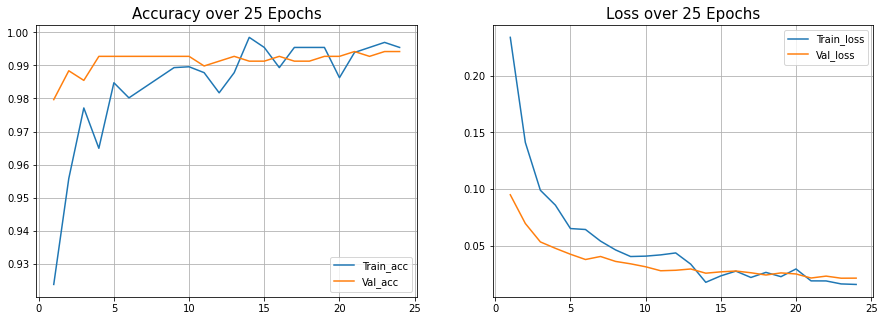

In [20]:
cnn.evaluate(testing_data, testing_label)

plot_acc_loss(history, 25)

In [21]:
cnn.save("model.h5")

In [22]:
cnn.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

In [23]:
def predict_image(img):
    
#     img = cv2.imread('/home/rupamay/Downloads/observations/experiments/data/without_mask/0.jpg')

    img = cv2.resize(img, (224,224))

    img = img.astype(np.float32)

    img = img / 255

    img = tf.expand_dims(img, axis=0)

    pred=cnn.predict(img)[0]
    
    class_names=['With Mask', 'Without Mask']

    pred_class = class_names[pred.argmax()]

    
    return pred_class


In [30]:
import gradio as gr

gr.Interface(fn=predict_image, inputs="image", outputs="label",title="Mask/NoMask",
             description="Classify a person with mask or without mask").launch(share=True,inline=False)
 

Running on local URL:  http://127.0.0.1:7863
Running on public URL: https://15643f455509d66d76.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces
